# Practice univariate LSTM 

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.dates as mdates
import seaborn as sns

/Users/asumisaito/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/asumisaito/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/asumisaito/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [20]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

/Users/asumisaito/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/asumisaito/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.


In [5]:
df = pd.read_csv('/Users/asumisaito/Downloads/dengue_features_train.csv')
df2 = pd.read_csv('/Users/asumisaito/Downloads/dengue_labels_train.csv')
data =  pd.merge(df, df2, on = ['city', 'year', 'weekofyear'])

In [6]:
data.head(3)

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.12260,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.16990,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.03225,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4


In [8]:
import datetime
data['date'] = data['week_start_date'].astype(str).apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d'))

In [9]:
list(data)

['city',
 'year',
 'weekofyear',
 'week_start_date',
 'ndvi_ne',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'precipitation_amt_mm',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'station_precip_mm',
 'total_cases',
 'date']

# Data cleaning

### Try with this data
- city = 'sj'
- train: first 13 years (1990-04-30 to 2003-04-30)
- test: last 5 years (2003-05-01 to 2008-04-22)

In [13]:
data[data.city=='sj'].date.describe()

count                     936
unique                    936
top       2000-05-13 00:00:00
freq                        1
first     1990-04-30 00:00:00
last      2008-04-22 00:00:00
Name: date, dtype: object

In [41]:
data = data.sort_values(by=['date'])
sj = data[data.city == 'sj'].loc[:,['total_cases']]
sj.head(3)

,total_cases
date,
1990-04-30,4
1990-05-07,5
1990-05-14,4


In [95]:
# normalize features - 

scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(sj.values)
series = pd.DataFrame(scaled)


/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


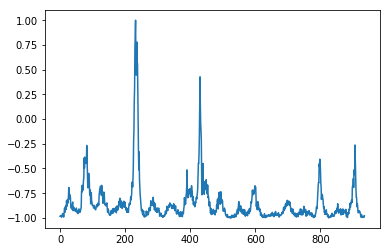

In [43]:
plt.plot(series.values)
plt.show()

### let's start with using 1-49th weeks to predict 50th week
- But this means I have 50 weeks lag values. Not practical

In [96]:
# fix the moving window size to be 50

window_size = 50

series_s = series.copy()
for i in range(window_size):
    series = pd.concat([series, series_s.shift(-(i+1))], axis = 1)
    
series.dropna(axis=0, inplace=True)

In [82]:
series.head()

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-0.982646,-0.978308,-0.982646,-0.986985,-0.973970,-0.991323,-0.982646,-0.978308,-0.956616,-0.973970,...,-0.917570,-0.891540,-0.921909,-0.908894,-0.926247,-0.926247,-0.930586,-0.930586,-0.934924,-0.900217
1,-0.978308,-0.982646,-0.986985,-0.973970,-0.991323,-0.982646,-0.978308,-0.956616,-0.973970,-0.965293,...,-0.891540,-0.921909,-0.908894,-0.926247,-0.926247,-0.930586,-0.930586,-0.934924,-0.900217,-0.930586
2,-0.982646,-0.986985,-0.973970,-0.991323,-0.982646,-0.978308,-0.956616,-0.973970,-0.965293,-0.991323,...,-0.921909,-0.908894,-0.926247,-0.926247,-0.930586,-0.930586,-0.934924,-0.900217,-0.930586,-0.926247
3,-0.986985,-0.973970,-0.991323,-0.982646,-0.978308,-0.956616,-0.973970,-0.965293,-0.991323,-0.973970,...,-0.908894,-0.926247,-0.926247,-0.930586,-0.930586,-0.934924,-0.900217,-0.930586,-0.926247,-0.947939
4,-0.973970,-0.991323,-0.982646,-0.978308,-0.956616,-0.973970,-0.965293,-0.991323,-0.973970,-0.926247,...,-0.926247,-0.926247,-0.930586,-0.930586,-0.934924,-0.900217,-0.930586,-0.926247,-0.947939,-0.926247


In [83]:
len(sj)

936

In [97]:
# create train and test data

# use 670 rows as train
train = series.iloc[:670, :]
test = series.iloc[670:,:]

from sklearn.utils import shuffle
train = shuffle(train)

train_X = train.iloc[:,:-1]
train_y = train.iloc[:,-1]
test_X = test.iloc[:,:-1]
test_y = test.iloc[:,-1]


In [98]:
# convert df to array
train_X = train_X.values
train_y = train_y.values
test_X = test_X.values
test_y = test_y.values

print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(670, 50)
(670,)
(216, 50)
(216,)


In [99]:
train_X = train_X.reshape(train_X.shape[0],train_X.shape[1],1)
test_X = test_X.reshape(test_X.shape[0],test_X.shape[1],1)
print(train_X.shape, test_X.shape)

(670, 50, 1) (216, 50, 1)


In [100]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(input_shape = (50,1), output_dim= 50, return_sequences = True))
model.add(Dropout(0.5))
model.add(LSTM(256))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss="mse", optimizer="adam")
model.summary()

/Users/asumisaito/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(50, 1), return_sequences=True, units=50)`
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 256)               314368    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 325,025
Trainable params: 325,025
Non-trainable params: 0
_________________________________________________________________


In [103]:
start = time.time()
model.fit(train_X,train_y,batch_size=100,nb_epoch=6,validation_split=0.1)
print("> Compilation Time : ", time.time() - start)

/Users/asumisaito/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 603 samples, validate on 67 samples
Epoch 1/6
603/603 [==============================] - 3s 4ms/step - loss: 0.0375 - val_loss: 0.0036
Epoch 2/6
603/603 [==============================] - 2s 4ms/step - loss: 0.0343 - val_loss: 0.0034
Epoch 3/6
603/603 [==============================] - 2s 4ms/step - loss: 0.0331 - val_loss: 0.0045
Epoch 4/6
603/603 [==============================] - 2s 4ms/step - loss: 0.0321 - val_loss: 0.0026
Epoch 5/6
603/603 [==============================] - 2s 4ms/step - loss: 0.0311 - val_loss: 0.0094
Epoch 6/6
603/603 [==============================] - 2s 4ms/step - loss: 0.0305 - val_loss: 0.0023
> Compilation Time :  14.514081954956055


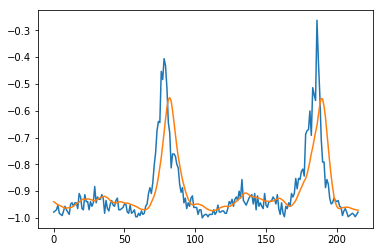

In [104]:
preds = model.predict(test_X)

plt.plot(test_y)
plt.plot(preds)
plt.show()

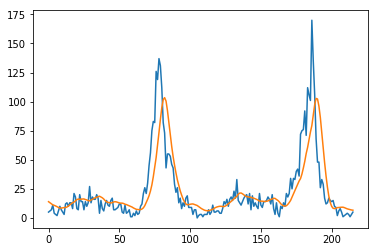

In [105]:
preds = model.predict(test_X)
preds2 = scaler.inverse_transform(preds)
actual = scaler.inverse_transform(test_y.reshape(-1, 1))
plt.plot(actual)
plt.plot(preds2)
plt.show()

In [ ]:
# of course it goes very good accuracy

## Moving test window

In [66]:
def moving_test_window_preds(n_future_preds):

    ''' 
    n_future_preds - Represents the number of future predictions we want to make
                         This coincides with the number of windows that we will move forward
                         on the test data
    '''
    preds_moving = []                                    
    # Use this to store the prediction made on each test window
    
    moving_test_window = [test_X[0,:].tolist()]          
    # Creating the first test window
    
    moving_test_window = np.array(moving_test_window)    
    # Making it an numpy array
    
    for i in range(n_future_preds):
        preds_one_step = model.predict(moving_test_window) 
        # Note that this is already a scaled prediction so no need to rescale this
        
        preds_moving.append(preds_one_step[0,0]) 
        # get the value from the numpy 2D array and append to predictions
        
        preds_one_step = preds_one_step.reshape(1,1,1) 
        # Reshaping the prediction to 3D array for concatenation with moving test window
        
        moving_test_window = np.concatenate((moving_test_window[:,1:,:], preds_one_step), axis=1) 
        # This is the new moving test window, where the first element from the window has been removed and the prediction  has been appended to the end
    
    preds_moving = np.array(preds_moving)
    preds_moving = scaler.inverse_transform(preds_moving.reshape(-1, 1))
    
    return preds_moving

In [87]:
# normalize features - 

scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(sj.values)
series = pd.DataFrame(scaled)


/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [88]:
# fix the moving window size to be 50

window_size = 50

series_s = series.copy()
for i in range(window_size):
    series = pd.concat([series, series_s.shift(-(i+1))], axis = 1)
    
series.dropna(axis=0, inplace=True)

In [89]:
# create train and test data

# use 400 rows as train, 200 as test, rest as validation
train = series.iloc[:400, :]
test = series.iloc[400:600,:]
validation = series.iloc[600:, :]

from sklearn.utils import shuffle
train = shuffle(train)

train_X = train.iloc[:,:-1]
train_y = train.iloc[:,-1]
test_X = test.iloc[:,:-1]
test_y = test.iloc[:,-1]

# convert df to array
train_X = train_X.values
train_y = train_y.values
test_X = test_X.values
test_y = test_y.values

print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

train_X = train_X.reshape(train_X.shape[0],train_X.shape[1],1)
test_X = test_X.reshape(test_X.shape[0],test_X.shape[1],1)
print(train_X.shape, test_X.shape)

(400, 50)
(400,)
(200, 50)
(200,)
(400, 50, 1) (200, 50, 1)


In [90]:
len(validation)

286

In [106]:
preds = moving_test_window_preds(216)

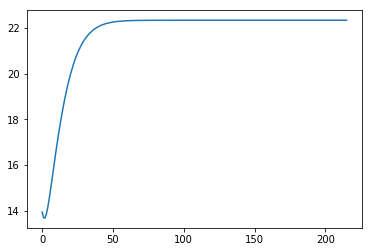

In [107]:
plt.plot(preds)
plt.show()